## NOTE: This notebook is still under development to accomodate BIDS data formatting

Due to some peculiarities in the data logging process and the format of BIDS behavioral data, it is difficult to align the raw logs with classifier probabilities to the rest of the behavioral data from the closed-loop sessions (requires using epoch time on the task computer, since this matches the time in the logs).

The correctly aligned events are in `data/processed_events_NiclsCourierClosedLoop.csv` and we hope to eventually reproduce this file from scratch using only BIDS-formatted data.

In [3]:
import os
import cmlreaders as cml
import numpy as np
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = None
import datetime
import pytz
import scipy as scp
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['savefig.facecolor']='white'
import seaborn as sns
sns.set_palette('hls', 3)
import pickle
from mne_bids import (BIDSPath, read_raw_bids, find_matching_paths)
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster


# use subjects with complete data
subject_list = np.loadtxt("final_subject_list.txt", dtype=str)

In [2]:
# if running locally
# client = Client()

# if running on HPC
client = Client(
    SLURMCluster(
        job_name="NICLS",
        memory="2GB",
        cores=1,
        processes=1,
        walltime="01:00:00",
        local_directory=os.path.expanduser("~/dask-worker-space/"),
        log_directory=os.path.expanduser("~/logs/")
    )
)
# adavptively scale workers based on demand
client.cluster.adapt(minimum=0, maximum=100)

In [4]:
# cl_data = cml.get_data_index(kind = 'ltp');
# cl_data = cl_data[cl_data['experiment'] == 'NiclsCourierClosedLoop']
# cl_data = cl_data.query("subject in @subject_list")

bids_root = os.path.expanduser("/data8/NICLS_BIDS/")
event_paths = find_matching_paths(
    root=bids_root,
    tasks="NiclsCourierClosedLoop",
    subjects=subject_list,
    suffixes="events",
    extensions=".tsv"
    )
eeg_paths = find_matching_paths(
    root=bids_root,
    tasks="NiclsCourierClosedLoop",
    subjects=subject_list,
    suffixes="eeg",
    extensions=".bdf"
    )

In [6]:
eeg.info.get("meas_date")

NameError: name 'eeg' is not defined

In [148]:
# TODO: in BIDS format the onset is based on EEG computer time, not task computer time
eeg = read_raw_bids(eeg_paths[0], extra_params=dict(preload=False))
eeg_start = eeg.info.get("meas_date").replace(tzinfo=None)
eeg_start = pytz.timezone('US/Eastern').localize(eeg_start).astimezone(pytz.utc)
evs = pd.read_csv(event_paths[0].fpath, sep='\t')
orig_evs = cml.CMLReader(subject=subject_list[0], experiment="NiclsCourierClosedLoop", session=0).load("task_events")[['type', 'item', 'mstime']]

Extracting EDF parameters from /data8/NICLS_BIDS/sub-LTP462/ses-0/eeg/sub-LTP462_ses-0_task-NiclsCourierClosedLoop_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /data8/NICLS_BIDS/sub-LTP462/ses-0/eeg/sub-LTP462_ses-0_task-NiclsCourierClosedLoop_events.tsv.
Reading channel info from /data8/NICLS_BIDS/sub-LTP462/ses-0/eeg/sub-LTP462_ses-0_task-NiclsCourierClosedLoop_channels.tsv.
Reading electrode coords from /data8/NICLS_BIDS/sub-LTP462/ses-0/eeg/sub-LTP462_ses-0_space-CapTrak_electrodes.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info


/tmp/ipykernel_127221/223797726.py:2: RuntimeWarning: The unit for channel(s) EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  eeg = read_raw_bids(eeg_paths[0], extra_params=dict(preload=False))
/tmp/ipykernel_127221/223797726.py:2: RuntimeWarning: The unit for channel(s) Status has changed from NA to V.
  eeg = read_raw_bids(eeg_paths[0], extra_params=dict(preload=False))
/tmp/ipykernel_127221/223797726.py:2: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
  eeg = read_raw_bids(eeg_paths[0], extra_params=dict(preload=False))
/tmp/ipykernel_127221/223797726.py:2: RuntimeWarning: Not setting positions of 9 eog/misc/stim channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels wh

In [56]:
datetime.datetime.fromtimestamp(messages.loc[23, 'time'], tz=datetime.timezone.utc)

datetime.datetime(2021, 10, 15, 13, 27, 13, 406933, tzinfo=datetime.timezone.utc)

In [182]:
pd.to_datetime(evs.query("trial_type=='CLASSIFIER'")['onset']+eeg_start.timestamp(), unit='s', origin='unix')

93     2021-10-15 13:35:38.455566336
97     2021-10-15 13:35:57.986816512
101    2021-10-15 13:36:22.936035072
105    2021-10-15 13:36:42.584961024
108    2021-10-15 13:36:55.316894464
                    ...             
1383   2021-10-15 15:08:21.593261824
1388   2021-10-15 15:08:29.208984320
1393   2021-10-15 15:08:36.892089856
1398   2021-10-15 15:08:46.674804736
1403   2021-10-15 15:08:55.989746176
Name: onset, Length: 206, dtype: datetime64[ns]

In [179]:
pd.to_datetime(orig_evs.query("type=='CLASSIFIER'")['mstime'], unit="ms", utc=True)

93     2021-10-15 13:35:39.053000+00:00
97     2021-10-15 13:35:58.586000+00:00
101    2021-10-15 13:36:23.537000+00:00
105    2021-10-15 13:36:43.187000+00:00
108    2021-10-15 13:36:55.920000+00:00
                     ...               
1383   2021-10-15 15:08:22.587000+00:00
1388   2021-10-15 15:08:30.203000+00:00
1393   2021-10-15 15:08:37.887000+00:00
1398   2021-10-15 15:08:47.670000+00:00
1403   2021-10-15 15:08:56.986000+00:00
Name: mstime, Length: 206, dtype: datetime64[ns, UTC]

In [174]:
pd.to_datetime(messages.query("type=='CLASSIFIER_RESULT'")['task pc time'])

110      2021-10-15 13:27:19.638422+00:00
112      2021-10-15 13:27:19.832017+00:00
113      2021-10-15 13:27:19.838534+00:00
116      2021-10-15 13:27:20.041543+00:00
117      2021-10-15 13:27:20.055355+00:00
                       ...               
155802   2021-10-15 15:18:50.344075+00:00
155806   2021-10-15 15:18:50.529440+00:00
155808   2021-10-15 15:18:50.573518+00:00
155810   2021-10-15 15:18:50.698449+00:00
155812   2021-10-15 15:18:50.787465+00:00
Name: task pc time, Length: 53576, dtype: datetime64[ns, UTC]

In [186]:
# log = pd.read_json(f"/data/eeg/scalp/ltp/NiclsCourierClosedLoop/{event_paths[0].subject}/session_{event_paths[0].session}/session.jsonl", lines=True)
# networks = log.query("type == 'network'")['data'].apply(pd.Series)
# networks['sent'] = networks['sent'].apply(eval)
# messages = networks.query("~sent")['message'].apply(pd.Series)
# load epoch and result events, replace time with outermost time in logs (should match onset)
epoch = pd.concat([messages.query("type=='EEG_EPOCH_END'").drop(columns="data"),
                    messages.query("type=='EEG_EPOCH_END'")['data'].apply(pd.Series)], axis=1)#.drop(columns='time')
# epoch = pd.concat([epoch, log.loc[epoch.index]['time']], axis=1)
classifier_result = pd.concat([messages.query("type=='CLASSIFIER_RESULT'").drop(columns="data"),
                                messages.query("type=='CLASSIFIER_RESULT'")['data'].apply(pd.Series)], axis=1)#.drop(columns='time')
# classifier_result = pd.concat([classifier_result, log.loc[classifier_result.index]['time']], axis=1)
classifier_result = epoch.merge(classifier_result, on="id", suffixes=["_eeg_epoch", "_class_result"])
classifier_result = classifier_result[['id', 'time_eeg_epoch', 'time_class_result', 
                                        "eeg collection duration", "classifier duration", 
                                        "normalized", "result", "probability"]]

In [195]:
messages.type.unique()

array(['CONNECTED_OK', 'CONFIGURE_OK', 'EEG_EPOCH_END',
       'CLASSIFIER_RESULT'], dtype=object)

In [189]:
classifier_result['time_class_result'].apply(lambda x: datetime.datetime.fromtimestamp(x, tz=datetime.timezone.utc))

0       2021-10-15 13:27:19.639374+00:00
1       2021-10-15 13:27:19.832247+00:00
2       2021-10-15 13:27:19.839333+00:00
3       2021-10-15 13:27:20.042300+00:00
4       2021-10-15 13:27:20.056164+00:00
                      ...               
53571   2021-10-15 15:18:50.343546+00:00
53572   2021-10-15 15:18:50.528302+00:00
53573   2021-10-15 15:18:50.573030+00:00
53574   2021-10-15 15:18:50.697971+00:00
53575   2021-10-15 15:18:50.786939+00:00
Name: time_class_result, Length: 53576, dtype: datetime64[ns, UTC]

In [183]:
def load_merged_events(event_path, eeg_path):
    # get eeg start time
    eeg = read_raw_bids(eeg_path, extra_params=dict(preload=False))
    eeg_start = eeg.info.get("meas_date").replace(tzinfo=None)
    eeg_start = pytz.timezone('US/Eastern').localize(eeg_start).astimezone(pytz.utc)
    eeg_start = eeg_start.timestamp()
    # load behavioral events
    evs = pd.read_csv(event_path.fpath, sep='\t')
    # convert to unix timestamp in ms, which matches logs
    evs['onset'] += eeg_start
    evs["onset"] *= 1000
    for trial, trial_evs in evs.groupby("trial"):
        evs["recalled"] = trial_evs.query("trial_type=='WORD'")\
            .apply(lambda x: x["item"] in trial_evs.query("trial_type=='REC_WORD'").item.values, axis=1)
    evs.drop(index=evs[evs.trial_type.str.contains('VV')].index, inplace=True)
    evs.drop(index=evs.query("phase in ['practice', 'movie', 'video']").index, inplace=True)
    
    res = evs.groupby(['subject','session', 'trial']).agg({'classifier':lambda x: list(np.unique([i for i in x if i!='X'])) or 'NoStim'})
    res = res.apply(lambda x: [i if isinstance(i, str) else i[0] for i in x])

    evs['condition']=''
    for (subject, session, trial), row in res.iterrows():
        idx = evs.query(f"subject=='{subject}' & session=={session} & trial=={trial}").index
        # evs['condition'][idx] = [row['classifier']]*len(idx)
        evs.loc[idx, 'condition'] = row['classifier']
    evs = evs[['sample','onset', 'classifier', 'trial_type', 'item', 'itemno', 
               'phase', 'session', 'trial', 'condition', 'subject', 'experiment', 'store', 'recalled']].sort_values("onset")
    # merge with logs that have extended classifier info 
    log = pd.read_json(f"/data/eeg/scalp/ltp/NiclsCourierClosedLoop/{event_path.subject}/session_{event_path.session}/session.jsonl", lines=True)
    networks = log.query("type == 'network'")['data'].apply(pd.Series)
    networks['sent'] = networks['sent'].apply(eval)
    messages = networks.query("~sent")['message'].apply(pd.Series)
    # load epoch and result events, replace time with outermost time in logs (should match onset)
    epoch = pd.concat([messages.query("type=='EEG_EPOCH_END'").drop(columns="data"),
                       messages.query("type=='EEG_EPOCH_END'")['data'].apply(pd.Series)], axis=1)#.drop(columns='time')
    # epoch = pd.concat([epoch, log.loc[epoch.index]['time']], axis=1)
    classifier_result = pd.concat([messages.query("type=='CLASSIFIER_RESULT'").drop(columns="data"),
                                  messages.query("type=='CLASSIFIER_RESULT'")['data'].apply(pd.Series)], axis=1)#.drop(columns='time')
    # classifier_result = pd.concat([classifier_result, log.loc[classifier_result.index]['time']], axis=1)
    classifier_result = epoch.merge(classifier_result, on="id", suffixes=["_eeg_epoch", "_class_result"])
    classifier_result = classifier_result[['id', 'time_eeg_epoch', 'time_class_result', 
                                           "eeg collection duration", "classifier duration", 
                                           "normalized", "result", "probability"]]
    classifier_result['trial_type'] = 'CLASSIFIER'
    classifier_result = classifier_result.astype(
        {"time_class_result":'int64', "time_eeg_epoch":'int64', "id":'int64'}
        ).sort_values('time_class_result')
    evs = evs.astype({"onset":'int64'})
    merged_events = pd.merge_asof(
        evs,
        classifier_result, 
        left_on='onset', right_on='time_class_result',
        tolerance=100, direction='nearest', by='trial_type'
    )
    merged_events["onset"] /= 1000
    merged_events["onset"] -= eeg_start
    return merged_events

In [184]:
merged = load_merged_events(event_paths[0], eeg_paths[0])

Extracting EDF parameters from /data8/NICLS_BIDS/sub-LTP462/ses-0/eeg/sub-LTP462_ses-0_task-NiclsCourierClosedLoop_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /data8/NICLS_BIDS/sub-LTP462/ses-0/eeg/sub-LTP462_ses-0_task-NiclsCourierClosedLoop_events.tsv.
Reading channel info from /data8/NICLS_BIDS/sub-LTP462/ses-0/eeg/sub-LTP462_ses-0_task-NiclsCourierClosedLoop_channels.tsv.
Reading electrode coords from /data8/NICLS_BIDS/sub-LTP462/ses-0/eeg/sub-LTP462_ses-0_space-CapTrak_electrodes.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info


/tmp/ipykernel_127221/554982174.py:3: RuntimeWarning: The unit for channel(s) EXG5, EXG6, EXG7, EXG8 has changed from V to NA.
  eeg = read_raw_bids(eeg_path, extra_params=dict(preload=False))
/tmp/ipykernel_127221/554982174.py:3: RuntimeWarning: The unit for channel(s) Status has changed from NA to V.
  eeg = read_raw_bids(eeg_path, extra_params=dict(preload=False))
/tmp/ipykernel_127221/554982174.py:3: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
  eeg = read_raw_bids(eeg_path, extra_params=dict(preload=False))
/tmp/ipykernel_127221/554982174.py:3: RuntimeWarning: Not setting positions of 9 eog/misc/stim channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating 

In [161]:
pd.read_csv("data/processed_events_NiclsCourierClosedLoop.csv").query("subject=='LTP462' & session==0 & type=='CLASSIFIER'")

,Unnamed: 0,eegoffset,mstime,classifier,type,item,itemno,phase,session,trial,trial_type,subject,experiment,eegfile,store,recalled,id,time_eeg_epoch,time_class_result,eeg collection duration,classifier duration,normalized,result,probability,wait_time,next_type,prev_type,orig_eegoffset
257,257,1051386.0,1634304939053,Pos,CLASSIFIER,DAFFODILS,-999,1,0,1,Pos,LTP462,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP462/experiments/Nic...,florist,1,4044.0,1.634305e+12,1.634305e+12,2.0,0.171522,True,1.0,0.503172,2349.0,WORD,CLASSIFIER_WAIT,1051557.0
261,261,1091385.0,1634304958586,Pos,CLASSIFIER,GLUE,-999,1,0,1,Pos,LTP462,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP462/experiments/Nic...,craft_shop,1,4200.0,1.634305e+12,1.634305e+12,2.0,0.171078,True,1.0,0.500376,999.0,WORD,CLASSIFIER_WAIT,1091557.0
265,265,1142480.0,1634304983537,Pos,CLASSIFIER,NAILGUN,-999,1,0,1,Pos,LTP462,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP462/experiments/Nic...,hardware_store,1,4399.0,1.634305e+12,1.634305e+12,2.0,0.172517,True,1.0,0.501461,2533.0,WORD,CLASSIFIER_WAIT,1142653.0
269,269,1182724.0,1634305003187,Pos,CLASSIFIER,SHORTS,-999,1,0,1,Pos,LTP462,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP462/experiments/Nic...,clothing_store,1,4557.0,1.634305e+12,1.634305e+12,2.0,0.170400,True,1.0,0.505986,2216.0,WORD,CLASSIFIER_WAIT,1182894.0
272,272,1208800.0,1634305015920,Pos,CLASSIFIER,DRUM_SET,-999,1,0,1,Pos,LTP462,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP462/experiments/Nic...,music_store,1,4659.0,1.634305e+12,1.634305e+12,2.0,0.168759,True,1.0,0.504372,517.0,WORD,CLASSIFIER_WAIT,1208969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,1378,12444672.0,1634310502587,Sham,CLASSIFIER,PEARLS,-999,2,0,9,Sham,LTP462,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP462/experiments/Nic...,jewelry_store,-999,48549.0,1.634311e+12,1.634311e+12,2.0,0.190408,True,0.0,0.470131,2167.0,CUED_REC_CUE,CLASSIFIER_WAIT,12444863.0
1382,1382,12460280.0,1634310510203,Sham,CLASSIFIER,TOWELS,-999,2,0,9,Sham,LTP462,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP462/experiments/Nic...,barber_shop,-999,48610.0,1.634311e+12,1.634311e+12,2.0,0.179602,True,0.0,0.458976,3216.0,CUED_REC_CUE,CLASSIFIER_WAIT,12460460.0
1386,1386,12476006.0,1634310517887,Sham,CLASSIFIER,PUPPETS,-999,2,0,9,Sham,LTP462,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP462/experiments/Nic...,toy_store,-999,48671.0,1.634311e+12,1.634311e+12,2.0,0.188876,True,1.0,0.510609,350.0,CUED_REC_CUE,CLASSIFIER_WAIT,12476195.0
1390,1390,12496030.0,1634310527670,Sham,CLASSIFIER,SOCKS,-999,2,0,9,Sham,LTP462,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP462/experiments/Nic...,clothing_store,-999,48749.0,1.634311e+12,1.634311e+12,2.0,0.200022,True,1.0,0.502837,1751.0,CUED_REC_CUE,CLASSIFIER_WAIT,12496230.0


In [185]:
merged.dropna(subset=['probability'])

,sample,onset,classifier,trial_type,item,itemno,phase,session,trial,condition,subject,experiment,store,recalled,id,time_eeg_epoch,time_class_result,eeg collection duration,classifier duration,normalized,result,probability


In [8]:
futures = client.map(load_merged_events, event_paths, eeg_paths)

In [9]:
from dask.distributed import progress
progress(futures)

VBox()

In [26]:
results = client.gather(futures)

KeyboardInterrupt: 

In [61]:
# concatenate results across sessions/subjects
CL_evs = pd.concat(results).sort_values(by=["subject", "session", "mstime", "type"])
CL_evs = CL_evs.reset_index(drop=True)
# compute waiting times
wait_df = []
for (sub, sess, tri), df in CL_evs.groupby(["subject", 'session', 'trial']):
    waits = df.query("type in ['CLASSIFIER', 'CLASSIFIER_WAIT', 'TIMEOUT']")[['mstime']].diff()[1::2]
    waits = waits.rename(columns={"mstime":"wait_time"})
    waits = pd.merge(df, waits, left_index=True, right_index=True, how='left')
    wait_df.append(waits)
CL_evs = pd.concat(wait_df).reset_index(drop=True)
# 
for i, row in CL_evs.iterrows():
    if i+1 < len(CL_evs):
        # record the adjacent events
        CL_evs.at[i, 'next_type'] = CL_evs.at[i+1, 'type']
        CL_evs.at[i+1, 'prev_type'] = CL_evs.at[i, 'type']
    if row["type"] in ['CLASSIFIER', 'TIMEOUT']:
        # fill in missing information from associated events
        # i.e. give classifier events info about memory events
        # and give memory events info about the classifier results
        CL_evs.at[i, 'item'] = CL_evs.at[i+1, 'item']
        CL_evs.at[i, 'recalled'] = CL_evs.at[i+1, 'recalled']
        CL_evs.at[i, 'store'] = CL_evs.at[i+1, 'store']
        if CL_evs.at[i+1, 'type']=='WORD':
            CL_evs.at[i+1, 'probability'] = row["probability"]
            CL_evs.at[i+1, 'classifier duration'] = row["classifier duration"]
            CL_evs.at[i+1, 'wait_time'] = row["wait_time"]
    else:
        continue
class_idx = CL_evs.query("type=='CLASSIFIER'").index
CL_evs.loc[class_idx, "orig_sample"] = CL_evs.loc[class_idx, "sample"]
CL_evs.loc[class_idx, "sample"] = CL_evs.loc[class_idx, 'sample'] - (
    (CL_evs['time_class_result'] - CL_evs['time_eeg_epoch'])
)
CL_evs.to_csv("data/processed_events_phase2.csv")

In [37]:
CL_evs.query("type=='WORD'").groupby(["subject", "session", "condition"]).agg({"recalled":"mean", "probability":"mean"})

recalled  probability
subject session trial_type                       
LTP462  0       Neg         0.333333     0.485012
                NoStim      0.633333          NaN
                Pos         0.666667     0.504499
                Sham        0.300000     0.487880
        1       Neg         0.622222     0.485941
...                              ...          ...
LTP500  2       Sham        0.600000     0.671470
        3       Neg         0.777778     0.174701
                NoStim      0.833333          NaN
                Pos         0.688889     0.946089
                Sham        0.633333     0.933399

[272 rows x 2 columns]

## Load processed events

In [3]:
CL_evs = pd.read_csv("data/processed_events_NiclsCourierClosedLoop.csv", index_col=0)
CL_evs['condition'] = CL_evs['condition'].replace({"Sham":"Control", "Pos":"Optimize", "Neg":"Impair"})

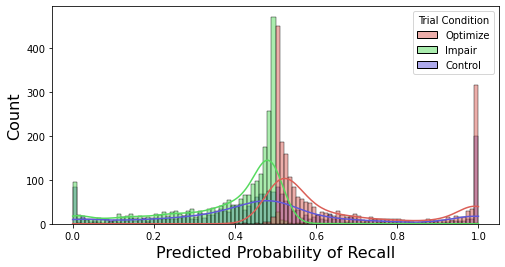

In [14]:
plt.figure(figsize=(8,4))
ax = sns.histplot(CL_evs.query("type=='WORD' and condition!='NoStim'"), x='probability', hue='condition', stat='count', bins=100, kde=True)
sns.move_legend(ax, 0, title="Trial Condition")
plt.xlabel("Predicted Probability of Recall")
plt.savefig("figures/classifier_prediction_dist.pdf", dpi=300, bbox_inches="tight")

### Classifier wait times

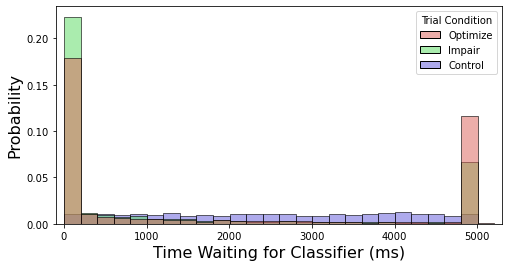

In [16]:
plt.figure(figsize=(8,4))
ax = sns.histplot(CL_evs.query("trial_type!='NoStim'"),
             x='wait_time', stat='probability', binwidth=200, hue='trial_type')
plt.xlim(-100, 5300)
plt.xlabel('Time Waiting for Classifier (ms)')
sns.move_legend(ax, None, title="Trial Condition")
plt.savefig("figures/classifier_wait_times.pdf", dpi=300, bbox_inches="tight")

## Apparent buggy behavior: not timing out

In [47]:
CL_evs[CL_evs['wait_time']>6000]

,eegoffset,mstime,classifier,type,item,itemno,phase,session,trial,trial_type,subject,experiment,eegfile,store,recalled,id,time_eeg_epoch,time_class_result,eeg collection duration,classifier duration,normalized,result,probability,wait_time,next_type,prev_type,orig_eegoffset
101666,3388492.0,1652121750505,Pos,CLASSIFIER,GARLIC,-999,1,2,2,Pos,LTP500,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP500/experiments/Nic...,pizzeria,-999,13137.0,1.652122e+12,1.652122e+12,2.0,0.191906,True,1.0,0.971811,7549.0,CUED_REC_CUE,CLASSIFIER_WAIT,3388684.0
101721,3569157.0,1652121838722,Pos,CLASSIFIER,KARAOKE_MACHINE,-999,1,2,2,Pos,LTP500,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP500/experiments/Nic...,toy_store,-999,13843.0,1.652122e+12,1.652122e+12,2.0,0.183047,True,1.0,0.765077,13733.0,CUED_REC_CUE,CLASSIFIER_WAIT,3569340.0
101777,4155263.0,1652122124922,Sham,CLASSIFIER,ORANGE_JUICE,-999,1,2,3,Sham,LTP500,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP500/experiments/Nic...,grocery_store,0,16132.0,1.652122e+12,1.652122e+12,2.0,0.172272,True,1.0,0.999990,8850.0,WORD,CLASSIFIER_WAIT,4155436.0
101778,4155436.0,1652122124922,X,WORD,ORANGE_JUICE,-999,1,2,3,Sham,LTP500,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP500/experiments/Nic...,grocery_store,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999990,8850.0,CLASSIFIER_WAIT,CLASSIFIER,NaN
101838,4742244.0,1652122411556,Sham,CLASSIFIER,SCONES,-999,1,2,3,Sham,LTP500,NiclsCourierClosedLoop,/protocols/ltp/subjects/LTP500/experiments/Nic...,cafe,-999,18425.0,1.652122e+12,1.652122e+12,2.0,0.175169,True,0.0,0.053994,9167.0,CUED_REC_CUE,CLASSIFIER_WAIT,4742420.0


### Very large gaps between eeg collection and classifier result

In [18]:
CL_evs["diff"] = CL_evs["time_class_result"]-CL_evs["time_eeg_epoch"]
CL_evs["overtime"] = CL_evs["classifier duration"]>6

In [19]:
CL_evs[["diff", "classifier duration", "type"]].dropna()

,diff,classifier duration,type
257,171.0,0.171522,CLASSIFIER
261,172.0,0.171078,CLASSIFIER
265,173.0,0.172517,CLASSIFIER
269,170.0,0.170400,CLASSIFIER
272,169.0,0.168759,CLASSIFIER
...,...,...,...
103430,204.0,0.203262,CLASSIFIER
103435,182.0,0.180348,CLASSIFIER
103440,168.0,0.167918,CLASSIFIER
103444,171.0,0.170764,CLASSIFIER


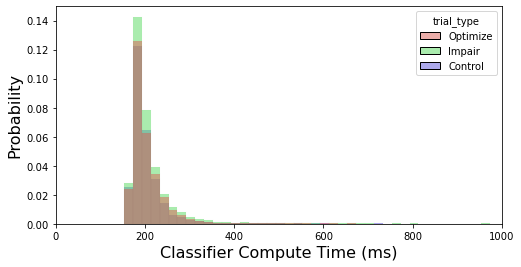

In [20]:
plt.figure(figsize=(8,4))
sns.histplot(CL_evs.dropna(subset=["diff"]),
             x='diff', stat='probability', binwidth=20, hue='trial_type')
plt.xlim(0, 1000)
plt.xlabel('Classifier Compute Time (ms)')
sns.move_legend(ax, None, title="Trial Condition")
plt.savefig("figures/classifier_compute_times.pdf", dpi=300, bbox_inches="tight")

## System Performance Statistics

In [92]:
pd.options.display.float_format = '{:.3f}'.format
performance_stats = CL_evs.query("type=='CLASSIFIER' and next_type=='WORD'").groupby(["subject", "session"]).agg(
    {"classifier duration":["mean", "median", "max"], "overtime":"mean"}
)
performance_stats['excluded'] = performance_stats['overtime']['mean']>=.05
performance_stats.to_csv("system_performance_stats.csv")
performance_stats

classifier duration              overtime excluded
                               mean median   max     mean         
subject session                                                   
LTP462  0                     0.207  0.185 1.367    0.000    False
        1                     0.193  0.185 0.337    0.000    False
LTP468  0                     0.212  0.197 0.440    0.000    False
        1                     0.190  0.181 0.444    0.000    False
LTP470  0                     0.215  0.202 0.506    0.000    False
...                             ...    ...   ...      ...      ...
LTP498  3                     0.195  0.188 0.363    0.000    False
LTP500  0                     0.203  0.192 0.434    0.000    False
        1                     0.215  0.202 0.603    0.000    False
        2                     0.179  0.176 0.236    0.000    False
        3                     0.192  0.185 0.290    0.000    False

[68 rows x 5 columns]

In [93]:
# performance_stats = pd.read_csv("data/system_performance_stats.csv", header=[0, 1], index_col=[0, 1])
performance_stats['classifier duration'] = (performance_stats['classifier duration']*1000).astype(int)
performance_stats = performance_stats.rename(columns={"classifier duration":"classifier duration (ms)"})

In [94]:
performance_stats

classifier duration (ms)              overtime excluded
                                    mean median   max     mean         
subject session                                                        
LTP462  0                            206    184  1367    0.000    False
        1                            193    184   337    0.000    False
LTP468  0                            212    197   440    0.000    False
        1                            190    181   444    0.000    False
LTP470  0                            215    201   506    0.000    False
...                                  ...    ...   ...      ...      ...
LTP498  3                            195    187   362    0.000    False
LTP500  0                            202    191   433    0.000    False
        1                            214    202   602    0.000    False
        2                            179    175   236    0.000    False
        3                            191    185   290    0.000    False

[68 rows x 5 columns]

In [95]:
caption = """
\/textbf{System Performance} Data for each subject and session in the
closed-loop dataset, detailing how long computation of classifier predictions
lasted and whether or not the duration of that computation exceeded our tolerance
threshold of 6 seconds (the maximum compute time that would still allow the
prediction to be actionable)
"""
with open("performance_stats.tex", "w") as f:
    f.write(performance_stats.to_latex(float_format="%.2f", longtable=True, 
                                       label="system_perfomance",
                                       caption=caption))